In [4]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow.keras.utils as ku 

import numpy as np

In [5]:
with open("data/data.txt", "r") as f:
    data = f.read()

corpus = data.lower().split("\n")

tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

# create input sequences using list of tokens
input_sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)


# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# create predictors and label
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]

label = ku.to_categorical(label, num_classes=total_words)

In [6]:
model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(150, return_sequences = True)))
model.add(Dropout(0.2))
model.add(LSTM(100))
model.add(Dense(total_words/2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(total_words, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 16, 100)           136400    
                                                                 
 bidirectional (Bidirectiona  (None, 16, 300)          301200    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 16, 300)           0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               160400    
                                                                 
 dense (Dense)               (None, 682)               68882     
                                                                 
 dense_1 (Dense)             (None, 1364)              931612    
                                                        

In [7]:
history = model.fit(predictors, label, epochs=100, verbose=1)
model.save("model.h5")

Epoch 1/100
192/192 [==============================] - 37s 146ms/step - loss: 6.6188 - accuracy: 0.0455
Epoch 2/100
192/192 [==============================] - 28s 145ms/step - loss: 5.8051 - accuracy: 0.0502
Epoch 3/100
192/192 [==============================] - 28s 146ms/step - loss: 5.5998 - accuracy: 0.0517
Epoch 4/100
192/192 [==============================] - 30s 156ms/step - loss: 5.4520 - accuracy: 0.0554
Epoch 5/100
192/192 [==============================] - 29s 151ms/step - loss: 5.2741 - accuracy: 0.0672
Epoch 6/100
192/192 [==============================] - 28s 145ms/step - loss: 5.1379 - accuracy: 0.0776
Epoch 7/100
192/192 [==============================] - 27s 143ms/step - loss: 5.0420 - accuracy: 0.0848
Epoch 8/100
192/192 [==============================] - 27s 143ms/step - loss: 4.9536 - accuracy: 0.0872
Epoch 9/100
192/192 [==============================] - 27s 141ms/step - loss: 4.8742 - accuracy: 0.0911
Epoch 10/100
192/192 [==============================] - 27s 141m

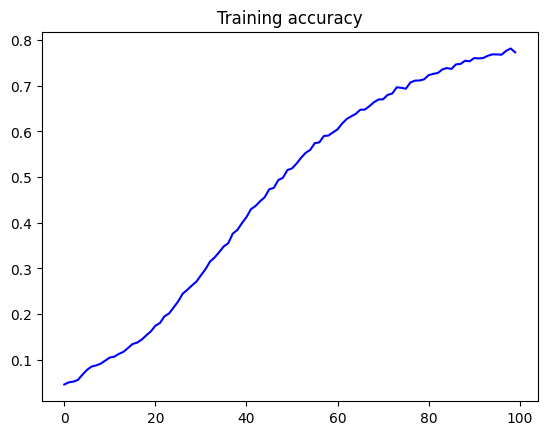

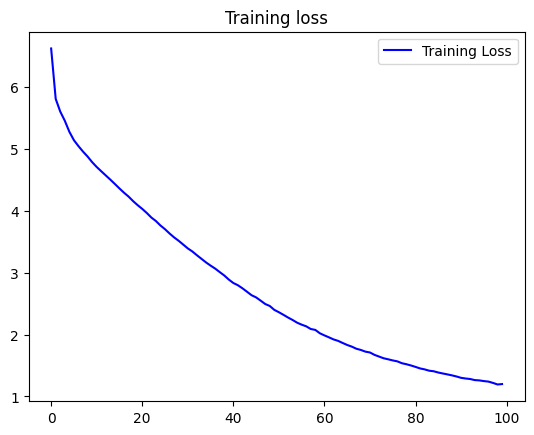

In [8]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [9]:
def predict(seedText, nWords=100):
    seedText = "I really like the Arctic Monkeys and "
    
    for _ in range(nWords):
        token_list = tokenizer.texts_to_sequences([seedText])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        predicted = model.predict_classes(token_list, verbose=0)
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        seedText += " " + output_word
    
    return seedText